# Job Role Clustering


#### This notebook identifies latent job roles by clustering job postings using skills + description text, then prepare outputs for interpretation in the next notebook.

### Load Data

In [1]:
import pandas as pd

df = pd.read_csv("/content/combined_with_skills_norm_v1.csv")
df.shape

/tmp/ipython-input-1960700287.py:3: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/combined_with_skills_norm_v1.csv")


(129334, 15)

### Prepare Text for Clustering

In [2]:
df["skill_text"] = df["skills_norm"].fillna("").apply(
    lambda x: " ".join(eval(x)) if isinstance(x, str) else ""
)

df["cluster_text"] = (
    df["skill_text"] + " " + df["clean_description"]
).str.strip()

### Vectorization (TF-IDF)

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=3000,
    min_df=10,
    max_df=0.8,
    ngram_range=(1,2)
)

X_tfidf = vectorizer.fit_transform(df["cluster_text"])

### Dimensionality Reduction

In [4]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100, random_state=42)
X_reduced = svd.fit_transform(X_tfidf)

X_reduced.shape

(129334, 100)

### Choose Number of Clusters (k)

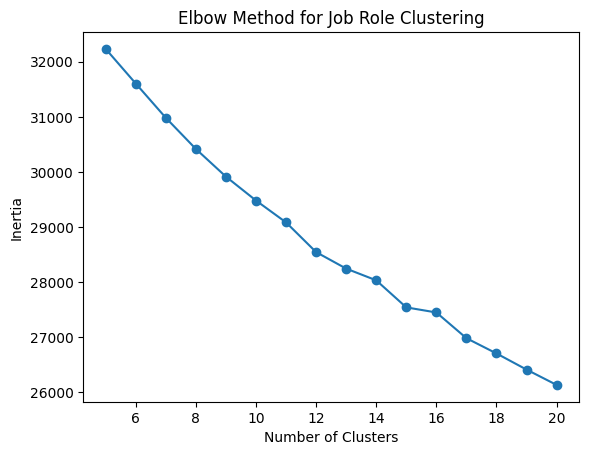

In [5]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
k_range = range(5, 21)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_reduced)
    inertia.append(km.inertia_)

plt.figure()
plt.plot(k_range, inertia, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Job Role Clustering")
plt.show()

### Final Clustering

In [6]:
from sklearn.cluster import KMeans

optimal_k = 10

kmeans = KMeans(
    n_clusters=optimal_k,
    random_state=42,
    n_init=20
)

df["job_cluster"] = kmeans.fit_predict(X_reduced)

### Save Clustered Dataset

In [7]:
df.to_csv("jobs_with_clusters_v1.csv", index=False)

### Inspect top skills per cluster

In [8]:
from collections import Counter

def top_skills(cluster_id, n=10):
    skills = []
    subset = df[df["job_cluster"] == cluster_id]["skills_norm"]
    for s in subset:
        skills.extend(s)
    return Counter(skills).most_common(n)

for i in sorted(df["job_cluster"].unique()):
    print(f"\nCluster {i}:")
    print(top_skills(i))


Cluster 0:
[("'", 8852), ('[', 6964), (']', 6964), ('e', 5536), ('c', 2757), ('l', 2751), ('x', 2668), ('a', 1095), (' ', 942), ('w', 914)]

Cluster 1:
[("'", 15038), ('[', 14762), (']', 14762), ('e', 7972), ('c', 4105), ('l', 3881), ('x', 3823), ('a', 2930), ('s', 2635), ('w', 2627)]

Cluster 2:
[("'", 13200), ('[', 9056), (']', 9056), ('e', 7371), ('l', 3675), ('c', 3652), ('x', 3443), ('t', 1820), ('i', 1817), (' ', 1750)]

Cluster 3:
[("'", 49646), ('[', 22412), (']', 22412), ('e', 19452), ('a', 10960), (' ', 10572), ('l', 10153), (',', 9858), ('c', 9425), ('s', 8571)]

Cluster 4:
[("'", 8032), ('e', 5646), ('[', 4504), (']', 4504), ('l', 2909), ('c', 2777), ('x', 2709), (' ', 1029), ('a', 907), (',', 905)]

Cluster 5:
[('[', 14559), (']', 14559), ("'", 13684), ('e', 8520), ('c', 4564), ('l', 3966), ('x', 3932), ('a', 2562), ('s', 1926), ('w', 1920)]

Cluster 6:
[("'", 8886), ('[', 7637), (']', 7637), ('e', 3678), ('a', 2279), ('w', 1988), ('s', 1984), ('c', 1957), ('l', 1709), ('

### Assign Labels to Clusters

In [9]:
cluster_labels = {
    0: "Project Management / Engineering",
    1: "Maintenance, Logistics & Warehouse Operations",
    2: "Sales & Business Development",
    3: "Administrative & Customer Support",
    4: "Accounting & Finance",
    5: "Healthcare & Nursing",
    6: "Retail Store Operations & Management",
    7: "Software, Data & Analytics",
    8: "Administrative, Legal & Support Services",
    9: "Sales Leadership & Management"
}

df["cluster_label"] = df["job_cluster"].map(cluster_labels)

In [10]:
df.to_csv("jobs_with_clusters_v1.csv", index=False)

## Skill Distribution per Cluster

In [11]:
df_exploded = df.explode("skills_norm")

cluster_skill_counts = (
    df_exploded
    .groupby(["cluster_label", "skills_norm"])
    .size()
    .reset_index(name="count")
)

top_skills = (
    cluster_skill_counts
    .sort_values(["cluster_label", "count"], ascending=[True, False])
    .groupby("cluster_label")
    .head(20)
)

## Skill Gap Analysis

### Prepare analysis dataset

In [19]:
import ast

df = pd.read_csv("/content/jobs_with_clusters_v1.csv")

df["skills_norm"] = df["skills_norm"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else []
)
df = df[
    (df["skills_norm"].apply(len) > 0) &
    (df["experience_level"].notna()) &
    (df["job_cluster"].notna())
]

/tmp/ipython-input-1694504278.py:3: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/jobs_with_clusters_v1.csv")


### Normalize experience levels

In [21]:
def map_experience(x):
    x = x.lower()
    if any(k in x for k in ["senior", "lead", "principal", "manager"]):
        return "senior"
    if any(k in x for k in ["entry", "junior", "associate", "intern"]):
        return "junior"
    return None

df["exp_group"] = df["experience_level"].apply(map_experience)
df = df[df["exp_group"].notna()]


### Compute skill frequency by cluster + experience

In [22]:
df_exp = df.explode("skills_norm")

skill_counts = (
    df_exp
    .groupby(["cluster_label", "exp_group", "skills_norm"])
    .size()
    .reset_index(name="count")
)


### Pivot junior vs senior

In [23]:
skill_pivot = (
    skill_counts
    .pivot_table(
        index=["cluster_label", "skills_norm"],
        columns="exp_group",
        values="count",
        fill_value=0
    )
    .reset_index()
)

skill_pivot["gap"] = skill_pivot["senior"] - skill_pivot["junior"]


### Filter meaningful gaps

In [24]:
skill_gap = skill_pivot[
    (skill_pivot["senior"] >= 50) &
    (skill_pivot["gap"] > 0)
].sort_values("gap", ascending=False)


### Visualization

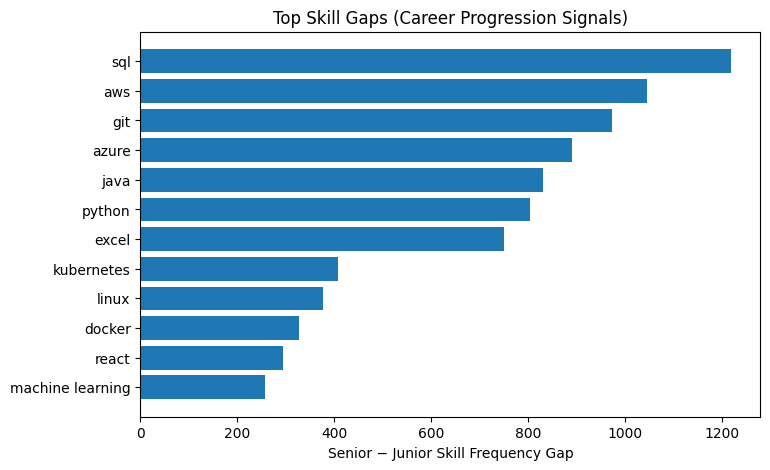

In [26]:
top_gap = skill_gap.head(15)

plt.figure(figsize=(8,5))
plt.barh(top_gap["skills_norm"], top_gap["gap"])
plt.xlabel("Senior − Junior Skill Frequency Gap")
plt.title("Top Skill Gaps (Career Progression Signals)")
plt.gca().invert_yaxis()
plt.show()


## Interpretation
### Job Role Clustering

- The elbow curve flattens around 12–14 clusters, indicating a reasonable separation of job roles.

- Beyond this range, additional clusters provide minimal reduction in inertia.

- This suggests the clustering captures meaningful job role structure without overfitting.

### Senior–Junior Skill Gaps

- SQL and cloud skills (AWS, Azure) show the largest gaps, highlighting their importance at senior levels.

- Git and core programming languages (Python, Java) increase significantly with seniority.

- DevOps tools (Docker, Kubernetes, Linux) appear as mid-level progression signals.

- Machine Learning shows a smaller gap, indicating it is role-specific rather than universally required.